# **Predictive Modeling of Breast Cancer using FNA Data**

About the Dataset:
The Breast Cancer Wisconsin dataset is a widely-used dataset in machine learning for binary classification tasks. It contains 569 samples with 30 features each, derived from digitized images of fine needle aspirates (FNAs) of breast masses. The features represent characteristics of cell nuclei, such as radius, texture, perimeter, area, and smoothness. The dataset is labeled with two possible outcomes: benign or malignant, making it a crucial resource for building predictive models in breast cancer diagnosis and research.



```
"""
MIT License

Copyright (c) 2024 Nidhi Umashankar and K Sai Geethanjali

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

```



# Pip Installations for Google Colab environment

In [1]:
!pip install optuna
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 48.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Pre-processng

In [3]:
# Loading the Breast Cancer Wisconsin (Diagnostic) dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
column_names = ['id', 'diagnosis', 'mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
                'mean_smoothness', 'mean_compactness', 'mean_concavity', 'mean_concave_points',
                'mean_symmetry', 'mean_fractal_dimension', 'se_radius', 'se_texture', 'se_perimeter',
                'se_area', 'se_smoothness', 'se_compactness', 'se_concavity', 'se_concave_points',
                'se_symmetry', 'se_fractal_dimension', 'worst_radius', 'worst_texture', 'worst_perimeter',
                'worst_area', 'worst_smoothness', 'worst_compactness', 'worst_concavity', 'worst_concave_points',
                'worst_symmetry', 'worst_fractal_dimension']

data = pd.read_csv(url, header=None, names=column_names, na_values='?')

# Displaying the first few rows of the dataset
print("Dataset Head:\n", data.head())

# Dropping the 'id' column and handle missing values
data = data.drop(columns=['id'])
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to binary

# Separating features and target variable
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

Dataset Head:
          id diagnosis  mean_radius  mean_texture  mean_perimeter  mean_area  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   mean_smoothness  mean_compactness  mean_concavity  mean_concave_points  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  worst_radius  worst_texture  worst_peri

# Feature selection & Data Splitting

In [4]:
# Applying feature selection to reduce dimensionality
selector = SelectKBest(f_classif, k=10)  # Adjust k as needed
X_selected = selector.fit_transform(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Displaying the sizes of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 455
Testing set size: 114


# Balancing Dataset & Reshaping Input for RNN

In [5]:
# Balancing the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Reshaping the data for RNN input (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Defining the RNN Model Using LSTM

In [6]:
# Defining the RNN model using LSTM
def create_rnn(learning_rate, l2_reg):
    model = Sequential([
        LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True, kernel_regularizer=l2(l2_reg)),
        Dropout(0.4),
        LSTM(64, return_sequences=False, kernel_regularizer=l2(l2_reg)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Using Optuna to Extract Best Hyperparameters

In [10]:
# Objective function for Optuna optimization for RNN
def rnn_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)
    rnn_model = create_rnn(learning_rate=learning_rate, l2_reg=l2_reg)

    # Progress bar for Optuna trials
    for _ in tqdm(range(1), desc="Training RNN model with Optuna"):
        rnn_model.fit(X_train_scaled, y_train_resampled, epochs=10, batch_size=32, verbose=0)  # Reduce epochs for optimization speed

    # Evaluating on the validation set
    score = rnn_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
    return score

# Running the Optuna optimization
rnn_study = optuna.create_study(direction='maximize')
rnn_study.optimize(rnn_objective, n_trials=30)

# Extracting the best hyperparameters for the RNN model
best_rnn_params = rnn_study.best_params
print("Best RNN hyperparameters:", best_rnn_params)

[I 2024-08-25 04:56:32,024] A new study created in memory with name: no-name-2779d2fa-10c9-4503-abf6-fc0e6fd2e34c
Training RNN model with Optuna: 100%|██████████| 1/1 [00:05<00:00,  5.48s/it]
[I 2024-08-25 04:56:38,140] Trial 0 finished with value: 0.9736841917037964 and parameters: {'learning_rate': 0.0029305296756154515, 'l2_reg': 4.0553002928161006e-05}. Best is trial 0 with value: 0.9736841917037964.
Training RNN model with Optuna: 100%|██████████| 1/1 [00:06<00:00,  6.66s/it]
[I 2024-08-25 04:56:45,422] Trial 1 finished with value: 0.9473684430122375 and parameters: {'learning_rate': 0.0006116475567933115, 'l2_reg': 0.00033400360323970063}. Best is trial 0 with value: 0.9736841917037964.
Training RNN model with Optuna: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]
[I 2024-08-25 04:56:51,672] Trial 2 finished with value: 0.9736841917037964 and parameters: {'learning_rate': 0.002157268713488151, 'l2_reg': 5.961292231218214e-05}. Best is trial 0 with value: 0.9736841917037964.
Traini

Best RNN hyperparameters: {'learning_rate': 0.0029305296756154515, 'l2_reg': 4.0553002928161006e-05}


# Using the Optimized RNN Model with Early Stopping and Fitting the Model

In [11]:
# Using the optimized RNN model with early stopping
def create_optimized_rnn():
    return create_rnn(
        learning_rate=best_rnn_params['learning_rate'],
        l2_reg=best_rnn_params['l2_reg']
    )

optimized_rnn_model = create_optimized_rnn()

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fitting the model
history = optimized_rnn_model.fit(
    X_train_scaled,
    y_train_resampled,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7702 - loss: 0.6526 - val_accuracy: 0.9130 - val_loss: 0.2558
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9211 - loss: 0.2890 - val_accuracy: 0.9130 - val_loss: 0.1725
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9332 - loss: 0.1766 - val_accuracy: 0.9565 - val_loss: 0.1385
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9565 - loss: 0.1285 - val_accuracy: 0.9739 - val_loss: 0.1070
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9448 - loss: 0.1508 - val_accuracy: 0.9739 - val_loss: 0.0960
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9413 - loss: 0.1570 - val_accuracy: 0.9739 - val_loss: 0.1010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9432 - loss: 0.1431 - val_accuracy: 0.9565 - val_loss: 0.1003
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9476 - loss: 0.1354 - val_accuracy: 0.9826 - val_lo

# Final predictions and Model Evaluation

In [12]:
# Making final predictions
y_pred_proba = optimized_rnn_model.predict(X_test_scaled)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("AUC-ROC:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Accuracy: 0.9736842105263158
AUC-ROC: 0.9967245332459876

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



# Plotting Curves to Evaluate the Model

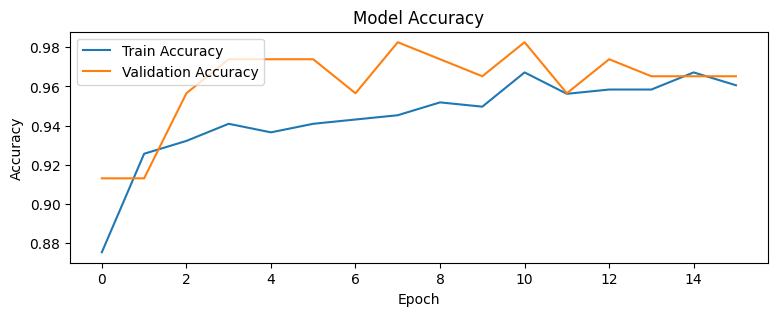

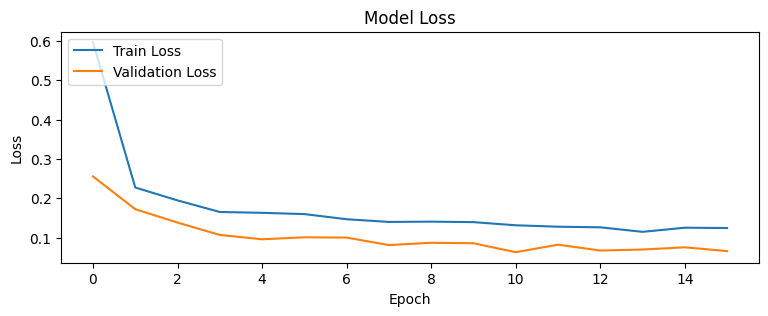

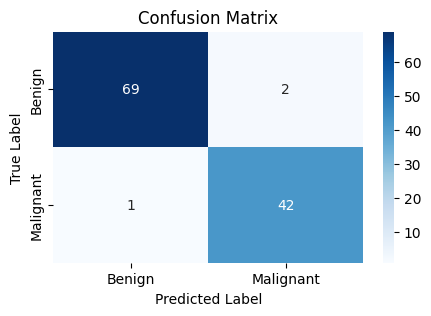

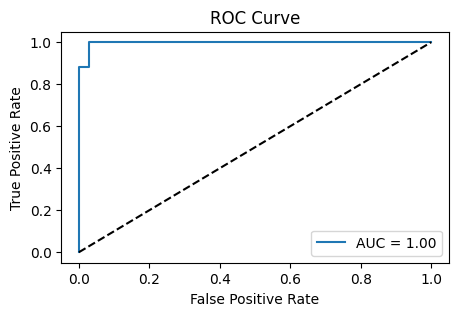

In [13]:
# Plotting training & validation accuracy values
plt.figure(figsize=(9, 3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.figure(figsize=(9, 3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plotting AUC-ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Additional Plots

In [14]:
# Additional Plots
plt.figure(figsize=(10, 3))

# Plotting Hyperparameter Importance from Optuna
optuna.visualization.plot_param_importances(rnn_study).show()

# Plotting Optimization History
optuna.visualization.plot_optimization_history(rnn_study).show()

<Figure size 1000x300 with 0 Axes>